# WASD: Wireless Anomaly Signal Dataset

* Authors: Jinha Kim (jinha.kim@o.cnu.ac.kr), Hyeongwoo Kim (Hyeongwoo.kim@o.cnu.ac.kr), Byungkwan Kim(byungkwan.kim@cnu.ac.kr)

* Version: 2024.10.21 

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

### STFT function for pytorch

In [2]:
def torch_stft(x):
    # sliding window 크기
    window_size = 3200
    # sliding window 구현
    
    unfolded = x.unfold(0, window_size, 810)
    unfolded = torch.fft.fftshift(torch.fft.fft(unfolded,dim=1),1)
    unfolded = unfolded[:-1,:]
    # unfolded = unfolded.numpy()
    return unfolded

### Tone anomaly signal generation function

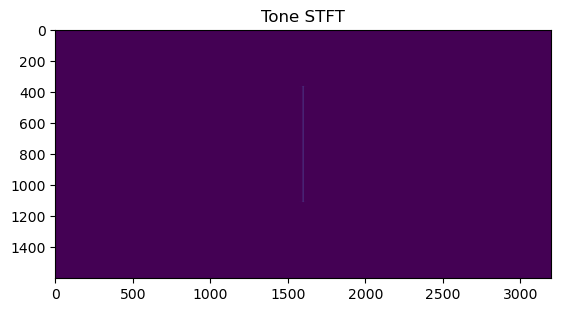

In [14]:
def tone_anomaly():
    sample_rate = 1300000.0  # in Hz
    duration = 1.0  # in seconds
    pulse_t = torch.zeros(1300000, dtype=torch.complex128)

    # Generate time values
    t = np.linspace(0, duration, int(sample_rate * duration))

    # Fixed carrier_frequency
    carrier_frequency = 0  # 고정된 주파수 값 (예: 600,000 Hz)
 
    start = 300000
    end = 900000

    pulse_t[start:end] = 1  # pulse_t[:start]과 pulse_t[end:]는 이미 0이므로 생략
    pulse_signal = pulse_t

    # 고정된 carrier_frequency와 offset을 사용하여 신호 생성
    tone_signal = pulse_signal * torch.tensor(
        np.cos(2 * np.pi * (carrier_frequency) * t) + 1j * np.sin(2 * np.pi * (carrier_frequency) * t)
    )
    return tone_signal
# 수정된 함수 호출
tone_signal= tone_anomaly()
tone_stft = torch_stft(tone_signal)

plt.title('Tone Signal Fourier Transform')
plt.imshow(np.abs(tone_stft.detach().cpu()))
plt.show()


### Chirp anomaly signal generation function

tensor([0.0000e+00, 7.6923e-07, 1.5385e-06,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00])


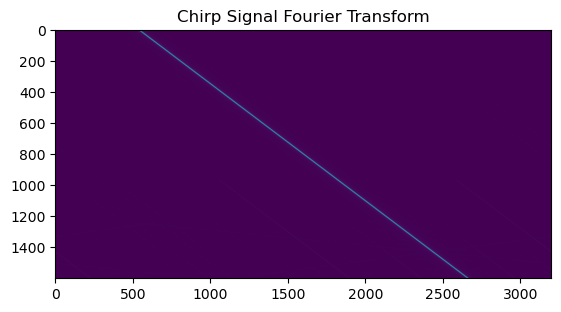

In [11]:
def chirp_anomaly():
    # Fixed parameters
    fs = 1300000            # Sampling frequency (1,300,000 Hz)
    num_points = 1300000    # Number of data points (1,300,000 samples)
    chirp_duration = 1    # Duration of the chirp in seconds
    
    # Frequency parameters
    f0 = -1300000/3              # Start frequency of the chirp
    f1 = 1300000/3        # End frequency of the chirp

    # Generate time values
    time = torch.linspace(0, chirp_duration, int(fs * chirp_duration))
    print(time)
    # Ensure the time vector matches the number of points
    time = time[:num_points]

    # Generate the chirp signal
    k = (f1 - f0) / chirp_duration  # Chirp rate
    chirp_signal = torch.exp(2j * np.pi * (f0 * time + 0.5 * k * time ** 2))

    # Pad or truncate the signal to match num_points
    if len(chirp_signal) < num_points:
        pad_size = num_points - len(chirp_signal)
        chirp_signal = torch.cat([chirp_signal, torch.zeros(pad_size, dtype=torch.cfloat)])
    else:
        chirp_signal = chirp_signal[:num_points]

    # Ensure the signal is complex64
    chirp_signal = chirp_signal.to(torch.complex64)
    torch.cuda.empty_cache()

    return chirp_signal

# Generate the chirp signal
chirp_signal = chirp_anomaly()
chirp_stft = torch_stft(chirp_signal)

plt.title('Chirp Signal Fourier Transform')
plt.imshow(np.abs(chirp_stft.detach().cpu()))
plt.show()

### Pulse anomaly signal generation function

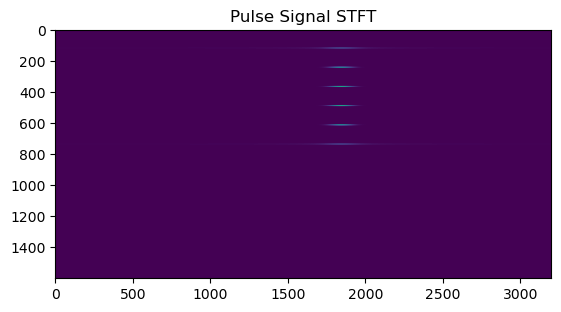

In [10]:
def pulse_anomaly():
    # Fixed parameters
    frequency_shift = 100000  # Fixed frequency shift
    sigma = 10  # Fixed sigma
    pulse_spacing = 100000  # Fixed pulse spacing
    num_points = 1300000  # Number of data points

    # Generate time values
    time = torch.linspace(0, 1, num_points)
    x = torch.arange(num_points, dtype=torch.float32)

    # Calculate the number of pulses
    num_pulses = int(num_points / pulse_spacing)

    # Create pulse centers
    pulse_centers = torch.arange(0, num_pulses * pulse_spacing, pulse_spacing, dtype=torch.float32)

    # Generate Gaussian pulse train
    X = x.unsqueeze(0)  # Shape: (1, num_points)
    C = pulse_centers.unsqueeze(1)  # Shape: (num_pulses, 1)
    pulse_train = torch.sum(torch.exp(-0.5 * ((X - C) / sigma) ** 2), dim=0)

    # Initialize pulse
    pulse = pulse_train

    # Define start and end indices for the pulse
    start = 100000  # Fixed start index
    end = 600000    # Fixed end index

    # Create pulse time mask
    pulse_time = torch.zeros(num_points)
    pulse_time[start:end] = 1
    pulse = pulse * pulse_time

    # Apply frequency shift
    pulse_signal = pulse * torch.exp(2j * np.pi * frequency_shift * time)

    # Ensure the signal is complex64
    pulse_signal = pulse_signal.to(torch.complex64)
    torch.cuda.empty_cache()

    return pulse_signal


pulse_signal = pulse_anomaly()
pulse_stft = torch_stft(pulse_signal)

plt.title('Pulse Signal STFT')
plt.imshow(np.abs(pulse_stft.detach().cpu()))
plt.show()